(7000, 30)


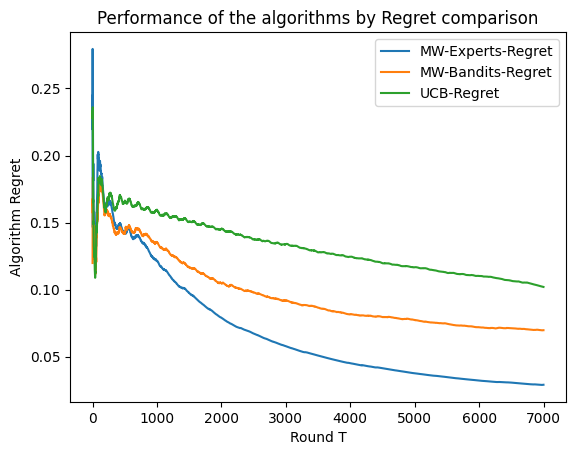

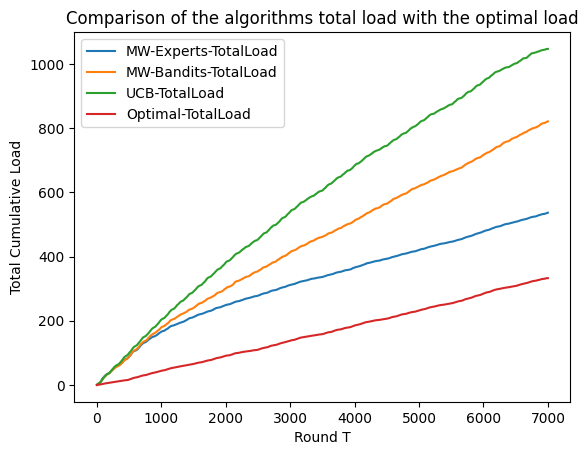

In [16]:
'''
Course: Reinforcement Learning and Dynamic Optimization / PLH-423
Professor: Thrasyboylos Spyropoylos
Author: Ioannis Peridis - 2018030069
Date: 19/04/2023
Assignment 2:
This program implements three different algorithms for optimizing server data distribution, depending on the server 
load at each timestep in a horizon T.The algorithms are Multicplicative Weights in an Experts environment and in a Bandits 
environment and Upper Confidence Bound modified to work with losses instead of rewards
'''
# import modules 
import csv
import numpy as np
import matplotlib.pyplot as plt 

# open the CSV file and read its contents, you have to add the file to the runtime so it can recognize it
with open('Milano_timeseries.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    # load the remaining rows into a matrix
    loads = np.array([row for row in reader]).astype(float).transpose()
# print the matrix's dimensions
print(loads.shape)

# general parameters initialization
T = loads.shape[0] # timestep horizon
k = loads.shape[1] # number of servers
eta = np.sqrt(np.log(k) / T) # η=(lnk/T)^(1/2), helps to discount the weights
epsilon = np.power((k * np.log(k)) / T, 1/3) # ε=(k*lnk/T)^(1/3), helps to add exploration probabbility
total_load_optimal = np.zeros(T) # total cumulative minimum load

# parameters of the experts algorithm
weights_experts = np.ones(k) # weights, are the trust factor of each expert 
probabilities_experts = np.zeros(k) # probabilities with whome we choose each expert
regret_experts = np.zeros(T) # algorithm regret, its the choosen load minus the minimum load
total_load_experts = np.zeros(T) # total cumulative algorithm regret 

# parameters of the bandit algorithm (same as before)
weights_bandits = np.ones(k)
probabilities_bandits = np.zeros(k)
#estimated_load_bandits = np.zeros(k) # estimated unbiased mean of each load
estimated_load_bandit = 0
regret_bandits = np.zeros(T)
total_load_bandits = np.zeros(T)

# parameters of the UCB algorithm
regret_UCB =  np.zeros(T) 
pulls_UCB = np.ones(k) # number of times that a server waqs choosen           
means_UCB = np.zeros(k) # mean loads choosen
total_loss_UCB = np.zeros(k) # total cumulative loss
bandit_UCB = np.zeros(k) # servers UCB values      
total_load_UCB = np.zeros(T)

'''This function is used to update the probabilities that the servers are choosen, it is used for both experts and bandits algoerithms'''
def update_probabilities(algorithm):
  if algorithm == "experts": # implementation for experts algorithm
    for li in range(k):
      probabilities_experts[li] = weights_experts[li] / np.sum(weights_experts) # probability that each expert is choosen
  elif algorithm == "bandits": # implementation for bandits algorithm
    for li in range(k):
      probabilities_bandits[li] = (1 - epsilon) * weights_experts[li] /  np.sum(weights_experts) + (epsilon / k) # probability that each bandit is choosen
  return

'''This function is used to select the server, it works for both experts and bandits algorithms and it picks the choosen 
server at random with the certain probability that each one has'''
def select_server(t, algorithm):
  if algorithm == "experts": # implementation for experts algorithm
    server_load = np.random.choice(loads[t], p=probabilities_experts) # picks a random load of a server, with certain probabilities
    server_index = np.where(loads[t] == server_load)[0][0]  # finds the server number that the load belongs to
  elif algorithm == "bandits": # implementation for bandits algorithm (same as the experts)
    server_load = np.random.choice(loads[t], p=probabilities_bandits)
    server_index = np.where(loads[t] == server_load)[0][0]
  return server_load, server_index

'''This function is used to update the weights, it works for both experts and bandits algorithms'''
def update_weights(t, algorithm, choosen):
  if algorithm == "experts": # implementation for experts algorithm
    for li in range(k):
      # updates all the weights with their loads , because they are known to us
      weights_experts[li] = (1 - eta)**loads[t][li] * weights_experts[li]
  elif algorithm == "bandits": # implementation for bandits algorithm
    # update just the choosen weight, by using the estimated mean load, because we dont have information for every load
    estimated_load_bandit = loads[t][choosen] / probabilities_bandits[choosen] # estimated unbiased means of the load
    weights_bandits[choosen] = (1 - eta)**estimated_load_bandit * weights_bandits[choosen]
  return

'''Multiplicative Weights algorithm implementation, its works for both experts and bandits algorithms, it takes as a parameter the timestep
and it calculates the probabilities of each server, selects the load and the server to choose and then updates the weights,
it uses all the above funcitons that they were explained'''
def multiplicative_weights(t, algorithm):
  if algorithm == "experts": # implementation for experts algorithm
    update_probabilities("experts")  # update probabilities that each server is choosen
    selected_load, selected_index = select_server(t, "experts") # find the load and the servers index number
    update_weights(t, "experts",selected_index) # update all the weights
  elif algorithm == "bandits": # implementation for bandits algorithm (same as before)
    update_probabilities("bandits")
    selected_load, selected_index = select_server(t, "bandits")
    # update estimated loads
    update_weights(t, "bandits", selected_index)
  return selected_load, selected_index

'''This function is used to update the server total load and the server's number of times that it was choosen'''
def update_arm(server):
  total_loss_UCB[server] += means_UCB[server] 
  pulls_UCB[server] += 1
  return

'''Upper Confidence Bound Algorithm implementation  ,takes as input the number of time 
steps and returns the load of the choosen server and the server number itself'''
def UCB(t):
  for li in range(k):
    # calculate the sample cumulative mean of the loads
    means_UCB[li] = loads[t][li]
    # calculate the UCB value, we use minus, because we are dealing with losses and not rewards
    bandit_UCB[li] = total_loss_UCB[li]/pulls_UCB[li] - np.sqrt(np.log(t+1)/pulls_UCB[li])
  best_UCB = np.amin(bandit_UCB) # find the best UCB arm and its value, best=minimum loss
  best_load_UCB = np.argmin(bandit_UCB)
  selected_load = loads[t][best_load_UCB] # choose the server with the best UCB score
  update_arm(best_load_UCB) # update the server you choose
  return selected_load, best_load_UCB

def main():
  for t in range(T): # with timestep 1 for the hall horizon T, repeat the above
    # function calling for every one of the algorithms, MW experts, MW bandits and UCB
    selected_load_experts, selected_index_experts = multiplicative_weights(t, "experts")
    selected_load_bandits, selected_index_bandits = multiplicative_weights(t, "bandits")
    selecetd_load_UCB, selected_index_UCB = UCB(t)
    # total cumulative load for every algorithm MW experts, MW bandits and UCB
    total_load_experts[t] = total_load_experts[t-1] + selected_load_experts
    total_load_bandits[t] = total_load_bandits[t-1] + selected_load_bandits
    total_load_UCB[t] = total_load_UCB[t-1] + selecetd_load_UCB
    # total cumulative optimal(minimum) load
    optimal_load = np.min(loads[t])
    optimal_index = np.where(loads[t] == optimal_load)[0][0]
    total_load_optimal[t] = total_load_optimal[t-1] + optimal_load
    # regret for each timestep for every algorithm ,MW experts, MW bandits and UCB
    # regret= algorithm load - optimal load (at every instance)
    regret_experts[t] = (total_load_experts[t] - total_load_optimal[t]) / (t + 1)
    regret_bandits[t] = (total_load_bandits[t] - total_load_optimal[t]) / (t + 1) 
    regret_UCB[t] = (total_load_UCB[t] - total_load_optimal[t]) / (t + 1) 
    # ! uncomment the code above if you want to print in a matrix form, the load that every different algorithm picks and the server index that it picks
    # compared to the optimal load and the optimal server number that it contains it !
    '''
    print("      | experts|bandits|UCB   |optimal|")
    print(f"server| {selected_index_experts:02d}     |{selected_index_bandits:02d}     |{selected_index_UCB:02d}    |{optimal_index:02d}     |")
    print(f"load  |{selected_load_experts:.3f}   |{selected_load_bandits:.3f}  |{selecetd_load_UCB:.3f} |{optimal_load:.3f}  |")
    print('-' * 40)
    '''
  # plot of the regret at each timestep of the MW-experts
  plt.title("Performance of the algorithms by Regret comparison") 
  plt.xlabel("Round T") 
  plt.ylabel("Algorithm Regret") 
  plt.plot(np.arange(0, T), regret_experts, label = "MW-Experts-Regret")
  plt.plot(np.arange(0, T), regret_bandits, label = "MW-Bandits-Regret") 
  plt.plot(np.arange(0, T), regret_UCB, label = "UCB-Regret") 
  plt.legend() 
  plt.show()
  print()
  # plot of the total loads of all 3 algorithms and of the optimal(minimum load) all in one plot so you can see the comparisons
  plt.title("Comparison of the algorithms total load with the optimal load") 
  plt.xlabel("Round T") 
  plt.ylabel("Total Cumulative Load") 
  plt.plot(np.arange(0, T), total_load_experts, label = 'MW-Experts-TotalLoad')
  plt.plot(np.arange(0, T), total_load_bandits, label = 'MW-Bandits-TotalLoad')
  plt.plot(np.arange(0, T), total_load_UCB, label = 'UCB-TotalLoad')
  plt.plot(np.arange(0, T), total_load_optimal, label = 'Optimal-TotalLoad')
  plt.legend() 
  plt.show()

if __name__ == '__main__':
  main()